In [1]:
import warnings
warnings.filterwarnings("ignore")
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import env, acquire, prepare

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.preprocessing import PolynomialFeatures

In [2]:
def get_connection(db, user=env.user, host=env.host, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

In [4]:
query = """select calculatedfinishedsquarefeet, bathroomcnt, bedroomcnt, taxvaluedollarcnt
           from properties_2017
           join predictions_2017 using(parcelid)
           where transactiondate between '2017-05-01' and '2017-06-30'
           and propertylandusetypeid in (261, 262, 263, 264, 266, 268, 273, 275, 276, 279)
        """

def get_zillow_data():
    filename = 'zillow.csv'
    
    if os.path.isfile(filename):
        return pd.read_csv(filename, index_col=0)
    else:
        df = pd.read_sql(query, get_connection('zillow'))
        df.to_csv(filename)
        return df

## Data Acquisition

In [31]:
df = acquire.acquire_cache_data()
df.head()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,taxvaluedollarcnt
0,1458.0,2.0,3.0,136104.0
1,1421.0,1.0,2.0,35606.0
2,2541.0,3.0,4.0,880456.0
3,1650.0,2.0,3.0,614000.0
4,693.0,1.0,2.0,274237.0


## Data Preparation
### Summarize the data
- df.info()
- df.describe()
- df.dtypes

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20364 entries, 0 to 20363
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   calculatedfinishedsquarefeet  20318 non-null  float64
 1   bathroomcnt                   20364 non-null  float64
 2   bedroomcnt                    20364 non-null  float64
 3   taxvaluedollarcnt             20364 non-null  float64
dtypes: float64(4)
memory usage: 636.5 KB


In [33]:
df. describe()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,taxvaluedollarcnt
count,20318.000000,20364.000000,20364.000000,2.036400e+04
mean,1776.493208,2.284694,3.019839,5.054039e+05
std,936.606498,0.958072,1.030974,6.584038e+05
min,242.000000,0.000000,0.000000,1.050400e+04
25%,1176.000000,2.000000,2.000000,2.104808e+05
50%,1536.000000,2.000000,3.000000,3.665045e+05
75%,2102.000000,3.000000,4.000000,5.890250e+05
max,15450.000000,11.000000,12.000000,2.385837e+07


In [34]:
df.dtypes

calculatedfinishedsquarefeet    float64
bathroomcnt                     float64
bedroomcnt                      float64
taxvaluedollarcnt               float64
dtype: object

### Address missing values
**Takeways**
- 70 observations has bathroom count 0
- 136 observations has bedroom count 0
- 46 observations has square feet as null
- How to deal with them? Drop all the observations with 0 or NaN values

In [35]:
df[df.bathroomcnt == 0].shape

(70, 4)

In [36]:
df[df.bedroomcnt == 0].shape

(136, 4)

In [37]:
df.calculatedfinishedsquarefeet.isnull().sum()

46

In [38]:
# Drop all the obervations with null or 0

mask_bathr = (df.bathroomcnt == 0)
mask_bedr = (df.bedroomcnt == 0)
mask_sf = df.calculatedfinishedsquarefeet.isnull()

mask = mask_bathr | mask_bedr | mask_sf
mask.sum()

df = df[-mask]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20223 entries, 0 to 20363
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   calculatedfinishedsquarefeet  20223 non-null  float64
 1   bathroomcnt                   20223 non-null  float64
 2   bedroomcnt                    20223 non-null  float64
 3   taxvaluedollarcnt             20223 non-null  float64
dtypes: float64(4)
memory usage: 790.0 KB


In [39]:
# Double check to make sure my code remove all the missing values.

bathr_missing = df[df.bathroomcnt == 0].shape[0]
bedr_missing = df[df.bedroomcnt == 0].shape[0]
sf_missing = df.calculatedfinishedsquarefeet.isnull().sum()

bathr_missing, bedr_missing, sf_missing

(0, 0, 0)

### Address dupliates
**Takeways**
- 61 obervations were duplicates
- How to deal with them? Drop all the duplicates

In [40]:
df.duplicated().sum()

58

In [41]:
df = df.drop_duplicates(keep='first', ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20165 entries, 0 to 20164
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   calculatedfinishedsquarefeet  20165 non-null  float64
 1   bathroomcnt                   20165 non-null  float64
 2   bedroomcnt                    20165 non-null  float64
 3   taxvaluedollarcnt             20165 non-null  float64
dtypes: float64(4)
memory usage: 630.3 KB


In [42]:
df.describe()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,taxvaluedollarcnt
count,20165.000000,20165.000000,20165.000000,2.016500e+04
mean,1780.902108,2.297595,3.041706,5.047822e+05
std,932.715302,0.948802,0.999601,6.554203e+05
min,242.000000,1.000000,1.000000,1.050400e+04
25%,1179.000000,2.000000,2.000000,2.107920e+05
50%,1540.000000,2.000000,3.000000,3.674520e+05
75%,2107.000000,3.000000,4.000000,5.900000e+05
max,15450.000000,11.000000,12.000000,2.385837e+07


### Visuzliaztion the variables

In [59]:
plt.rc('font',size=13)
plt.rc('figure', figsize=(16,9))

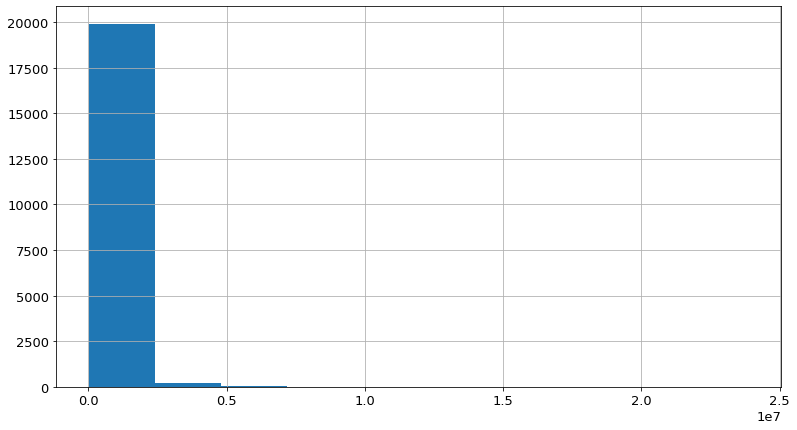

In [44]:
# Plot the distribution of the target variable: taxvaluedollarcnt

df.taxvaluedollarcnt.hist()

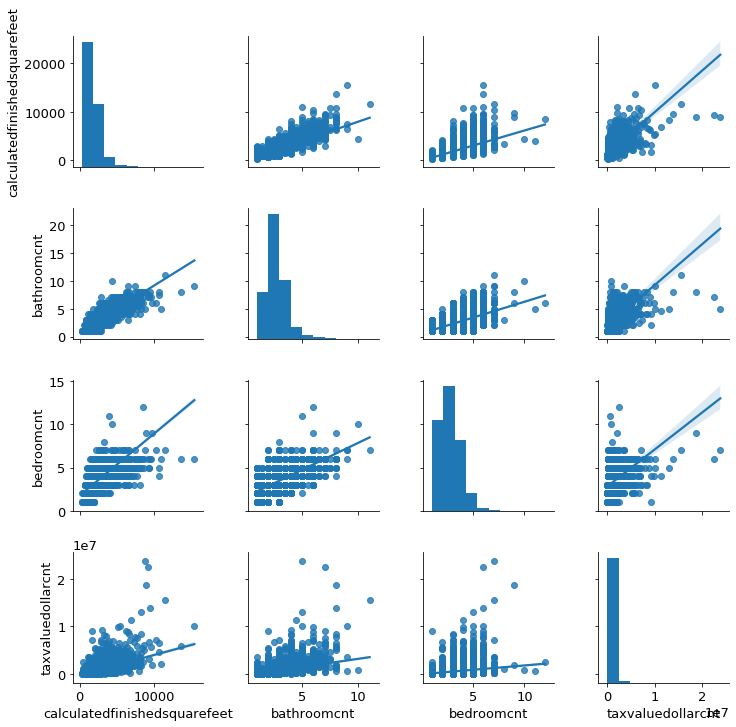

In [45]:
# Pairplot the variables

sns.pairplot(df, kind='reg')

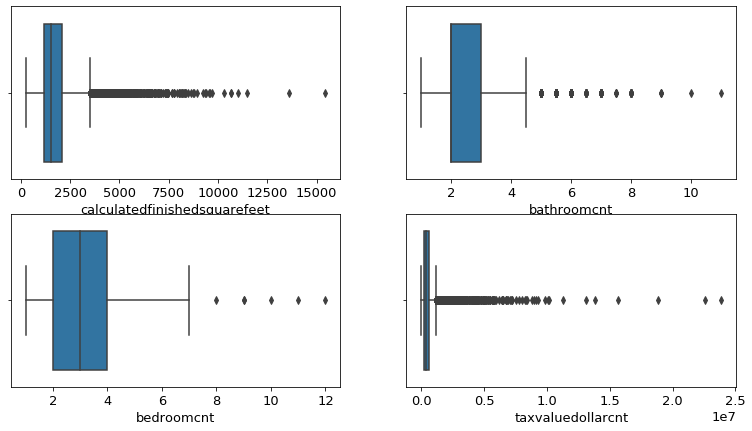

In [46]:
# Box-plot all the variables

plt.subplot(221)
sns.boxplot(df.calculatedfinishedsquarefeet)

plt.subplot(222)
sns.boxplot(df.bathroomcnt)

plt.subplot(223)
sns.boxplot(df.bedroomcnt)

plt.subplot(224)
sns.boxplot(df.taxvaluedollarcnt)

### Splitting the data into train, validate and test

In [47]:
df.head()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,taxvaluedollarcnt
0,1458.0,2.0,3.0,136104.0
1,1421.0,1.0,2.0,35606.0
2,2541.0,3.0,4.0,880456.0
3,1650.0,2.0,3.0,614000.0
4,693.0,1.0,2.0,274237.0


In [48]:
df.taxvaluedollarcnt

0        136104.0
1         35606.0
2        880456.0
3        614000.0
4        274237.0
           ...   
20160    359829.0
20161    297097.0
20162    746963.0
20163    579047.0
20164    630933.0
Name: taxvaluedollarcnt, Length: 20165, dtype: float64

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20165 entries, 0 to 20164
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   calculatedfinishedsquarefeet  20165 non-null  float64
 1   bathroomcnt                   20165 non-null  float64
 2   bedroomcnt                    20165 non-null  float64
 3   taxvaluedollarcnt             20165 non-null  float64
dtypes: float64(4)
memory usage: 630.3 KB


In [50]:
# from sklearn.model_selection import train_test_split

# train_validate, test = train_test_split(df, test_size=0.2, 
#                                             random_state=123,
#                                             stratify=df.taxvaluedollarcnt
#                                            )

In [51]:
import prepare

train, validate, test = prepare.split_my_data(df, pct=0.1)
train.shape, validate.shape, test.shape

((14518, 4), (3630, 4), (2017, 4))

In [52]:
train.head()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,taxvaluedollarcnt
16476,1476.0,2.0,3.0,409397.0
17919,1603.0,2.0,3.0,231346.0
3622,1579.0,2.0,3.0,169559.0
16863,1458.0,2.5,2.0,225597.0
15808,2338.0,3.0,4.0,288753.0


In [53]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14518 entries, 16476 to 18804
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   calculatedfinishedsquarefeet  14518 non-null  float64
 1   bathroomcnt                   14518 non-null  float64
 2   bedroomcnt                    14518 non-null  float64
 3   taxvaluedollarcnt             14518 non-null  float64
dtypes: float64(4)
memory usage: 567.1 KB


In [54]:
# # Value error when I tried to stratify the target variables

# train_stratified, validate_stratified, test_stratified = prepare.split_stratify_my_data(df,
#                                                                                         'taxvaluedollarcnt',
#                                                                                         pct=0.1)
# train_stratified.shape, validate_stratified.shape, test_stratified.shape

In [55]:
scaler, train_scaled, validate_scaled, test_scaled = prepare.min_max_scaler(train, validate, test)
train_scaled.shape, validate_scaled.shape, test_scaled.shape

((14518, 4), (3630, 4), (2017, 4))

In [56]:
train_scaled.head()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,taxvaluedollarcnt
16476,0.114492,0.111111,0.222222,0.017615
17919,0.126276,0.111111,0.222222,0.009729
3622,0.124049,0.111111,0.222222,0.006993
16863,0.112822,0.166667,0.111111,0.009475
15808,0.194470,0.222222,0.333333,0.012272


In [57]:
def prep_zillow(zillow):
    """
    Accpet the zillow dataframe acquired by function acquire_cache_data in acquire.py
    Return three splited dataframes scaled by min_max scaler: train_scaled, validate_scaled, test_scaled
    """
    mask_bathr = (zillow.bathroomcnt == 0)
    mask_bedr = (zillow.bedroomcnt == 0)
    mask_sf = zillow.calculatedfinishedsquarefeet.isnull()
    mask = mask_bathr | mask_bedr | mask_sf
    zillow = zillow[-mask]
    zillow = zillow.drop_duplicates(keep='first', ignore_index=True)
    train, validate, test = prepare.split_my_data(zillow, pct=0.1)
    scaler, train_scaled, validate_scaled, test_scaled = prepare.min_max_scaler(train, validate, test)
    return train_scaled, validate_scaled, test_scaled

In [58]:
zillow = acquire.acquire_cache_data()
zillow.head()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,taxvaluedollarcnt
0,1458.0,2.0,3.0,136104.0
1,1421.0,1.0,2.0,35606.0
2,2541.0,3.0,4.0,880456.0
3,1650.0,2.0,3.0,614000.0
4,693.0,1.0,2.0,274237.0


In [59]:
train_scaled, validate_scaled, test_scaled = prepare.prep_zillow(zillow)
train_scaled.head()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,taxvaluedollarcnt
16476,0.114492,0.111111,0.222222,0.017615
17919,0.126276,0.111111,0.222222,0.009729
3622,0.124049,0.111111,0.222222,0.006993
16863,0.112822,0.166667,0.111111,0.009475
15808,0.194470,0.222222,0.333333,0.012272


In [60]:
validate_scaled.head()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,taxvaluedollarcnt
13876,0.261459,0.388889,0.333333,0.020078
6471,0.134348,0.111111,0.333333,0.028051
8096,0.072370,0.055556,0.222222,0.020477
95,0.358415,0.333333,0.555556,0.017081
4969,0.132214,0.111111,0.111111,0.039345


In [61]:
test_scaled.head()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,taxvaluedollarcnt
18614,0.147152,0.222222,0.333333,0.038559
17346,0.047783,0.000000,0.111111,0.003003
7558,0.096957,0.166667,0.222222,0.011701
8780,0.142605,0.111111,0.222222,0.029557
8940,0.121451,0.111111,0.222222,0.016871


## Modeling
- MVP:
    - X: 'calculatedfinishedsquarefeet', 'bathroomcnt', 'bedroomcnt'
    - y: 'taxvaluedollarcnt'

In [62]:
train_scaled.columns

Index(['calculatedfinishedsquarefeet', 'bathroomcnt', 'bedroomcnt',
       'taxvaluedollarcnt'],
      dtype='object')

In [63]:
# Create X and y

X_train_scaled = train_scaled[['calculatedfinishedsquarefeet', 'bathroomcnt', 'bedroomcnt']]
y_train_scaled = train_scaled['taxvaluedollarcnt']

### Set up baseline

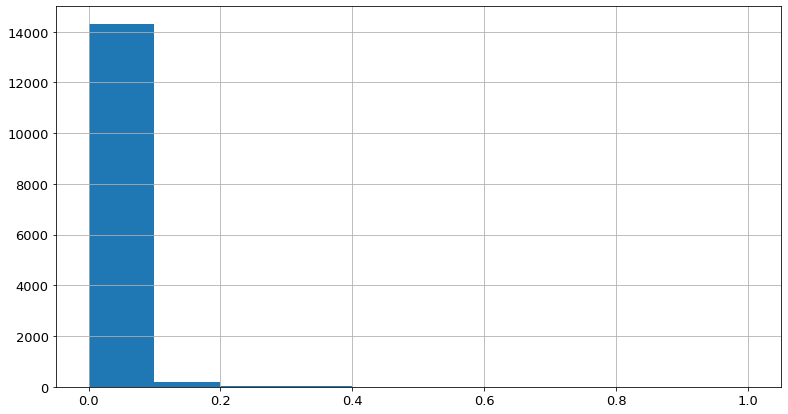

In [64]:
train_scaled.taxvaluedollarcnt.hist()

In [65]:
mean, median = train_scaled.taxvaluedollarcnt.agg(['mean', 'median'])
mean, median

(0.021679118375542906, 0.015692126737139968)

In [66]:
# Compute baseline prediction using mean

baseline = np.array([mean]*train_scaled.shape[0])
baseline[:5], len(baseline)

(array([0.02167912, 0.02167912, 0.02167912, 0.02167912, 0.02167912]), 14518)

In [67]:
# Compute baseline sse

baseline_residual = y_train_scaled - mean
baseline_sse = (baseline_residual**2).sum()
baseline_sse

11.533542707108785

In [68]:
# Compute baseline mse

baseline_mse = baseline_sse/train_scaled.shape[0]
baseline_mse

0.0007944305487745409

In [69]:
# Compute baseline rmse

baseline_rmse = mean_squared_error(y_train_scaled, baseline)**1/2
baseline_rmse

0.00039721527438727047

### Test 3 different algorithms for MVP
- LinearRegression
- LassoLars
- PolynomialFeatures + LinearRegression (2nd degree)

In [70]:
X_train_scaled.head()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt
16476,0.114492,0.111111,0.222222
17919,0.126276,0.111111,0.222222
3622,0.124049,0.111111,0.222222
16863,0.112822,0.166667,0.111111
15808,0.194470,0.222222,0.333333


In [71]:
y_train_scaled

16476    0.017615
17919    0.009729
3622     0.006993
16863    0.009475
15808    0.012272
           ...   
17329    0.017603
2367     0.023546
13173    0.026566
9199     0.004336
18804    0.002049
Name: taxvaluedollarcnt, Length: 14518, dtype: float64

### LinearRegression

In [72]:
# Create, fit, predict and calculate the lm_rmse

lm = LinearRegression(normalize=True)
lm.fit(X_train_scaled, y_train_scaled)
lm_pred = lm.predict(X_train_scaled)
lm_rmse = mean_squared_error(y_train_scaled, lm_pred)**1/2

lm_rmse

0.00024919734598661327

### LassoLars() for MVP

In [73]:
# Create, fit, predict and calculate the lars_rmse

lars = LassoLars(alpha=0.1)
lars.fit(X_train_scaled, y_train_scaled)
lars_pred = lars.predict(X_train_scaled)
lars_rmse = mean_squared_error(y_train_scaled, lars_pred)**1/2

lars_rmse

0.0003972152743872705

### PolynomialFeatures + LinearRegression
2nd degress polynomial

In [74]:
pf = PolynomialFeatures(degree=2)
X_train_scaled_squared = pf.fit_transform(X_train_scaled)

lm_squared = LinearRegression()
lm_squared.fit(X_train_scaled_squared, y_train_scaled)
lm_squared_pred = lm_squared.predict(X_train_scaled_squared)

lm_squared_rmse = mean_squared_error(y_train_scaled, lm_squared_pred)**1/2
lm_squared_rmse

0.0002332039338713283

### Validate top 2 algorithms for MVP
- LinearRegression
- PolynomialFeatures + LinearRegression (2nd degree)

In [75]:
# Create X and y

X_validate_scaled = validate_scaled[['calculatedfinishedsquarefeet', 'bathroomcnt', 'bedroomcnt']]
y_validate_scaled = validate_scaled['taxvaluedollarcnt']

In [76]:
validate_scaled.head()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,taxvaluedollarcnt
13876,0.261459,0.388889,0.333333,0.020078
6471,0.134348,0.111111,0.333333,0.028051
8096,0.072370,0.055556,0.222222,0.020477
95,0.358415,0.333333,0.555556,0.017081
4969,0.132214,0.111111,0.111111,0.039345


In [77]:
X_validate_scaled.head()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt
13876,0.261459,0.388889,0.333333
6471,0.134348,0.111111,0.333333
8096,0.072370,0.055556,0.222222
95,0.358415,0.333333,0.555556
4969,0.132214,0.111111,0.111111


In [78]:
y_validate_scaled.head()

13876    0.020078
6471     0.028051
8096     0.020477
95       0.017081
4969     0.039345
Name: taxvaluedollarcnt, dtype: float64

### LinearRegression

In [79]:
lm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [80]:
lm_pred = lm.predict(X_validate_scaled)
lm_rmse = mean_squared_error(y_validate_scaled, lm_pred)**1/2

lm_rmse

0.000344478679726347

### PolynomialFeatures + LinearRegression
2nd degress polynomial

In [81]:
pf

PolynomialFeatures(degree=2, include_bias=True, interaction_only=False,
                   order='C')

In [82]:
X_validate_scaled_squared = pf.transform(X_validate_scaled)
lm_squared_pred = lm_squared.predict(X_validate_scaled_squared)

lm_squared_rmse = mean_squared_error(y_validate_scaled, lm_squared_pred)**1/2
lm_squared_rmse

0.0003049063569313912

## Test 
### PolynomialFeatures + LinearRegression
2nd degress polynomial

In [87]:
test_scaled.head()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,taxvaluedollarcnt
18614,0.147152,0.222222,0.333333,0.038559
17346,0.047783,0.000000,0.111111,0.003003
7558,0.096957,0.166667,0.222222,0.011701
8780,0.142605,0.111111,0.222222,0.029557
8940,0.121451,0.111111,0.222222,0.016871


In [83]:
# Create X and y

X_test_scaled = test_scaled[['calculatedfinishedsquarefeet', 'bathroomcnt', 'bedroomcnt']]
y_test_scaled = test_scaled['taxvaluedollarcnt']

In [84]:
X_test_scaled.head()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt
18614,0.147152,0.222222,0.333333
17346,0.047783,0.000000,0.111111
7558,0.096957,0.166667,0.222222
8780,0.142605,0.111111,0.222222
8940,0.121451,0.111111,0.222222


In [86]:
y_test_scaled.head()

18614    0.038559
17346    0.003003
7558     0.011701
8780     0.029557
8940     0.016871
Name: taxvaluedollarcnt, dtype: float64

In [ ]:
X_test_scaled_squared = pf.transform(X_test_scaled)
lm_squared_pred = lm_squared.predict(X_test_scaled_squared)

lm_squared_rmse = mean_squared_error(y_test_scaled, lm_squared_pred)**1/2
lm_squared_rmse

# 2nd Iteration

### Data Acquisition

In [80]:
query = """
        SELECT *
        FROM properties_2017 AS p
        JOIN predictions_2017 AS pr USING (parcelid) 
        WHERE p.propertylandusetypeid IN (261, 262, 263, 264, 266, 268, 273, 275, 276, 279)
        AND pr.transactiondate between '2017-05-01' AND '2017-06-30'
        """

def get_zillow_data(iteration):
    zillow_csv = 'zillow_' + iteration + '.csv'
    filename = zillow_csv
    
    if os.path.isfile(filename):
        return pd.read_csv(filename, index_col=0)
    else:
        df = pd.read_sql(query, get_connection('zillow'))
        df.to_csv(filename)
        return df

In [81]:
df2 = get_zillow_data('2')
df2.head()

,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id.1,logerror,transactiondate
0,11289917,2061546,1.0,NaN,NaN,2.0,3.0,NaN,6.0,2.0,...,136104.0,2016.0,27214.0,2319.90,Y,15.0,6.037901e+13,1248,-0.362001,2017-06-23
1,11705026,1834372,NaN,NaN,NaN,1.0,2.0,NaN,6.0,1.0,...,35606.0,2016.0,23624.0,543.69,NaN,NaN,6.037232e+13,1772,-0.146056,2017-06-30
2,14269464,1923117,NaN,NaN,NaN,3.0,4.0,NaN,NaN,3.0,...,880456.0,2016.0,445569.0,9819.72,NaN,NaN,6.059064e+13,2028,0.021085,2017-06-01
3,11389003,2121349,NaN,NaN,NaN,2.0,3.0,NaN,6.0,2.0,...,614000.0,2016.0,449000.0,7673.19,NaN,NaN,6.037703e+13,3273,-0.325393,2017-06-01
4,11967869,2093710,NaN,NaN,NaN,1.0,2.0,NaN,5.0,1.0,...,274237.0,2016.0,191821.0,3267.47,NaN,NaN,6.037185e+13,3429,-0.005566,2017-06-29


In [84]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20364 entries, 0 to 20363
Data columns (total 62 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      20364 non-null  int64  
 1   id                            20364 non-null  int64  
 2   airconditioningtypeid         6506 non-null   float64
 3   architecturalstyletypeid      49 non-null     float64
 4   basementsqft                  11 non-null     float64
 5   bathroomcnt                   20364 non-null  float64
 6   bedroomcnt                    20364 non-null  float64
 7   buildingclasstypeid           0 non-null      float64
 8   buildingqualitytypeid         12623 non-null  float64
 9   calculatedbathnbr             20288 non-null  float64
 10  decktypeid                    175 non-null    float64
 11  finishedfloor1squarefeet      1671 non-null   float64
 12  calculatedfinishedsquarefeet  20318 non-null  float64
 13  f

### Filter features by the percentage of null values

In [82]:
# Compute the percentage of null values for each column. 

cols = df2.columns.tolist()
percentages = []
n_rows = df2.shape[0]

for col in cols:
    percentage = df2[col].isnull().sum()/n_rows
    percentages.append(percentage)
    
null_percentage = pd.DataFrame(percentages, index = cols)
null_percentage

,0
parcelid,0.000000
id,0.000000
airconditioningtypeid,0.680515
architecturalstyletypeid,0.997594
basementsqft,0.999460
...,...
taxdelinquencyyear,0.967344
censustractandblock,0.003781
id.1,0.000000
logerror,0.000000


In [83]:
# Select all the cols that have less than 20% of null values

mask = null_percentage[0] < 0.2
null_percentage[mask]

,0
parcelid,0.000000
id,0.000000
bathroomcnt,0.000000
bedroomcnt,0.000000
calculatedbathnbr,0.003732
calculatedfinishedsquarefeet,0.002259
finishedsquarefeet12,0.005107
fips,0.000000
fullbathcnt,0.003732
latitude,0.000000


### Initial visualization of selected variables

In [54]:
# Selected variables

features_target = ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
                   'fips', 'latitude', 'longitude', 
                   'lotsizesquarefeet', 'propertycountylandusecode','rawcensustractandblock', 
                   'regionidcity', 'regionidcounty','regionidzip',
                   'yearbuilt', 'censustractandblock', 'logerror', 
                   'taxvaluedollarcnt']

features = ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
            'fips', 'latitude', 'longitude', 'lotsizesquarefeet', 'propertycountylandusecode',
            'rawcensustractandblock', 'regionidcity', 'regionidcounty','regionidzip',
            'yearbuilt', 'censustractandblock', 'logerror']

target = ['taxvaluedollarcnt']

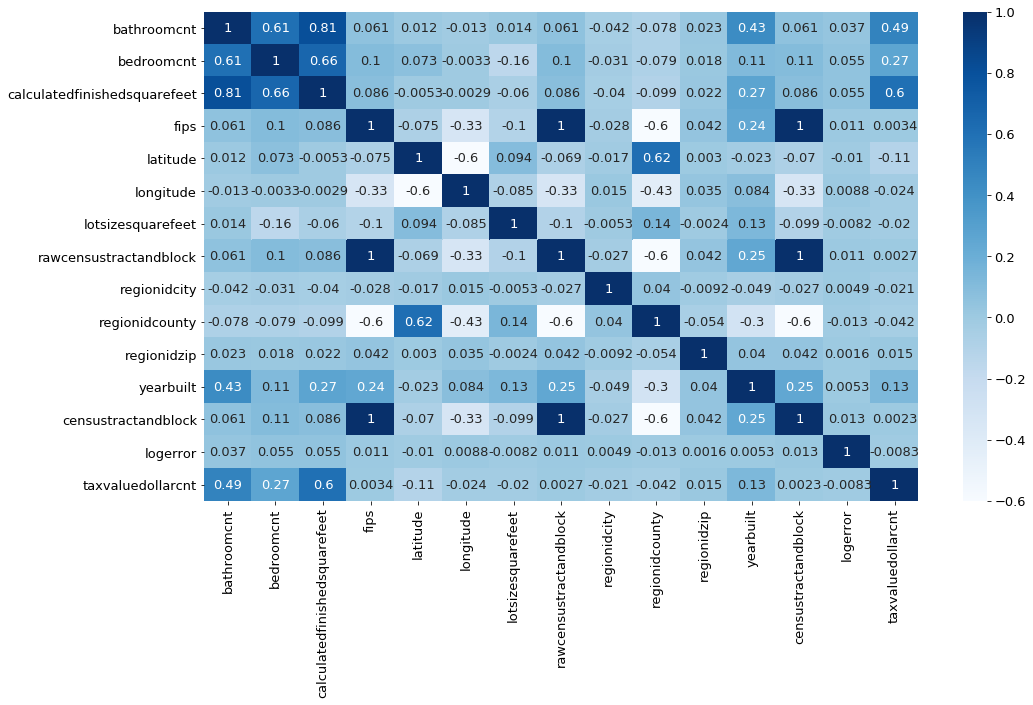

In [61]:
# corr_heatmap

df_vis = df2[features_target]
df_vis.head()

corr = df_vis.corr()
sns.heatmap(corr, cmap='Blues', annot=True)

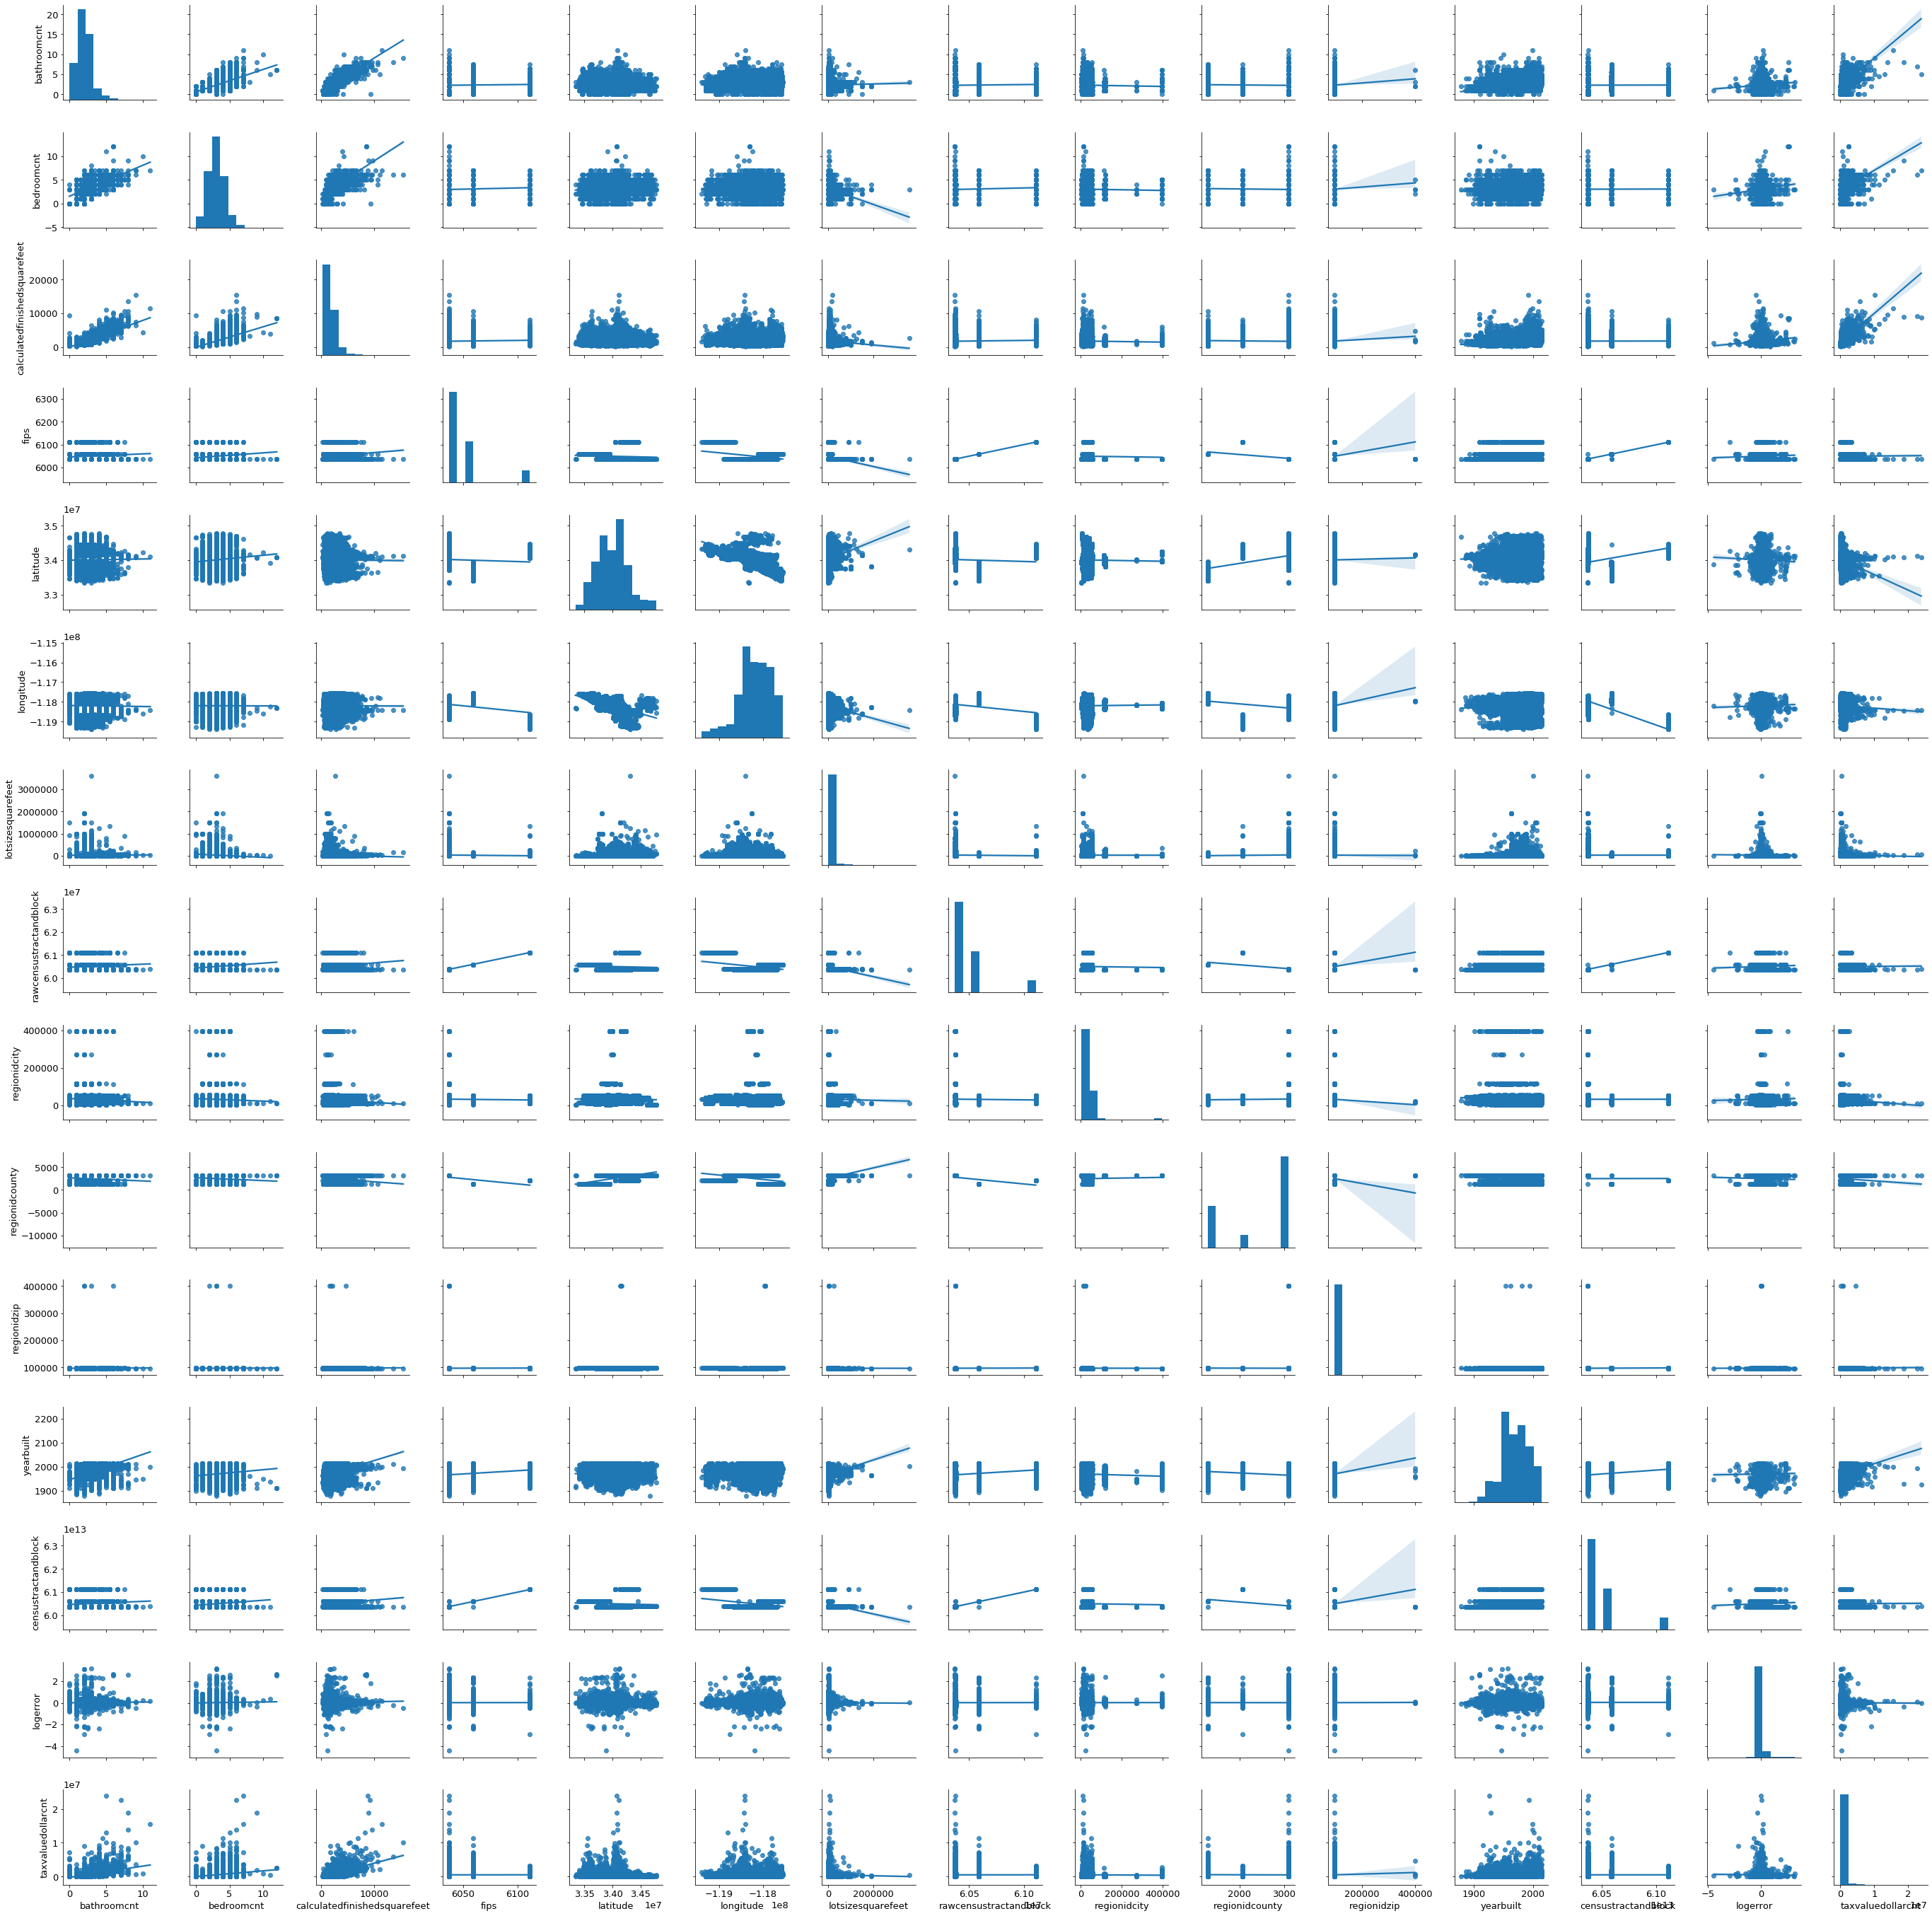

In [63]:
# Pairplot of selected features against target varibale

sns.pairplot(df_vis, kind='reg')

In [64]:
df_vis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20364 entries, 0 to 20363
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   20364 non-null  float64
 1   bedroomcnt                    20364 non-null  float64
 2   calculatedfinishedsquarefeet  20318 non-null  float64
 3   fips                          20364 non-null  float64
 4   latitude                      20364 non-null  float64
 5   longitude                     20364 non-null  float64
 6   lotsizesquarefeet             18104 non-null  float64
 7   propertycountylandusecode     20364 non-null  object 
 8   rawcensustractandblock        20364 non-null  float64
 9   regionidcity                  19999 non-null  float64
 10  regionidcounty                20364 non-null  float64
 11  regionidzip                   20350 non-null  float64
 12  yearbuilt                     20302 non-null  float64
 13  c

**Takeways**
1. fips are the same as rawcensustractandblock and censustractandblock since their correlations are 1.
2. the data needs to be prepared before feature engineering:
    - fips: convert to the name and get the dummies

### Data Preparation

In [65]:
# Create the dataframe that need to be wrangled

features = ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
            'fips', 'latitude', 'longitude',
            'lotsizesquarefeet', 'propertycountylandusecode', 'regionidcity', 
            'regionidcounty', 'regionidzip', 'yearbuilt', 
            'logerror']

target = ['taxvaluedollarcnt']

features_target = ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
                   'fips', 'latitude', 'longitude',
                   'lotsizesquarefeet', 'propertycountylandusecode', 'regionidcity', 
                   'regionidcounty', 'regionidzip', 'yearbuilt', 
                   'logerror', 
                   'taxvaluedollarcnt']

zillow2 = df2[features_target]
zillow2.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,regionidcity,regionidcounty,regionidzip,yearbuilt,logerror,taxvaluedollarcnt
0,2.0,3.0,1458.0,6037.0,34686163.0,-118113100.0,8284.0,0101,5534.0,3101.0,97318.0,1970.0,-0.362001,136104.0
1,1.0,2.0,1421.0,6037.0,33999877.0,-118291863.0,6707.0,0100,12447.0,3101.0,96018.0,1911.0,-0.146056,35606.0
2,3.0,4.0,2541.0,6059.0,33694636.0,-117912245.0,4975.0,1,38032.0,1286.0,96958.0,2003.0,0.021085,880456.0
3,2.0,3.0,1650.0,6037.0,33985377.0,-118361620.0,7300.0,0100,396550.0,3101.0,96037.0,1949.0,-0.325393,614000.0
4,1.0,2.0,693.0,6037.0,34112946.0,-118208106.0,2908.0,0100,12447.0,3101.0,96023.0,1921.0,-0.005566,274237.0


In [66]:
zillow2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20364 entries, 0 to 20363
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   20364 non-null  float64
 1   bedroomcnt                    20364 non-null  float64
 2   calculatedfinishedsquarefeet  20318 non-null  float64
 3   fips                          20364 non-null  float64
 4   latitude                      20364 non-null  float64
 5   longitude                     20364 non-null  float64
 6   lotsizesquarefeet             18104 non-null  float64
 7   propertycountylandusecode     20364 non-null  object 
 8   regionidcity                  19999 non-null  float64
 9   regionidcounty                20364 non-null  float64
 10  regionidzip                   20350 non-null  float64
 11  yearbuilt                     20302 non-null  float64
 12  logerror                      20364 non-null  float64
 13  t

In [72]:
# Drop the observations with missing values

cols = zillow2.columns.tolist()

for col in cols:
    mask = zillow2[col].isnull()
    zillow2 = zillow2[-mask]
    
zillow2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17721 entries, 0 to 20363
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   17721 non-null  float64
 1   bedroomcnt                    17721 non-null  float64
 2   calculatedfinishedsquarefeet  17721 non-null  float64
 3   fips                          17721 non-null  float64
 4   latitude                      17721 non-null  float64
 5   longitude                     17721 non-null  float64
 6   lotsizesquarefeet             17721 non-null  float64
 7   propertycountylandusecode     17721 non-null  object 
 8   regionidcity                  17721 non-null  float64
 9   regionidcounty                17721 non-null  float64
 10  regionidzip                   17721 non-null  float64
 11  yearbuilt                     17721 non-null  float64
 12  logerror                      17721 non-null  float64
 13  t

In [73]:
zillow2.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,regionidcity,regionidcounty,regionidzip,yearbuilt,logerror,taxvaluedollarcnt
0,2.0,3.0,1458.0,6037.0,34686163.0,-118113100.0,8284.0,0101,5534.0,3101.0,97318.0,1970.0,-0.362001,136104.0
1,1.0,2.0,1421.0,6037.0,33999877.0,-118291863.0,6707.0,0100,12447.0,3101.0,96018.0,1911.0,-0.146056,35606.0
2,3.0,4.0,2541.0,6059.0,33694636.0,-117912245.0,4975.0,1,38032.0,1286.0,96958.0,2003.0,0.021085,880456.0
3,2.0,3.0,1650.0,6037.0,33985377.0,-118361620.0,7300.0,0100,396550.0,3101.0,96037.0,1949.0,-0.325393,614000.0
4,1.0,2.0,693.0,6037.0,34112946.0,-118208106.0,2908.0,0100,12447.0,3101.0,96023.0,1921.0,-0.005566,274237.0


In [78]:
# Drop the duplicates

zillow2 = zillow2.drop_duplicates(keep='first', ignore_index=True)
zillow2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17720 entries, 0 to 17719
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   17720 non-null  float64
 1   bedroomcnt                    17720 non-null  float64
 2   calculatedfinishedsquarefeet  17720 non-null  float64
 3   fips                          17720 non-null  float64
 4   latitude                      17720 non-null  float64
 5   longitude                     17720 non-null  float64
 6   lotsizesquarefeet             17720 non-null  float64
 7   propertycountylandusecode     17720 non-null  object 
 8   regionidcity                  17720 non-null  float64
 9   regionidcounty                17720 non-null  float64
 10  regionidzip                   17720 non-null  float64
 11  yearbuilt                     17720 non-null  float64
 12  logerror                      17720 non-null  float64
 13  t

In [79]:
zillow2.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,regionidcity,regionidcounty,regionidzip,yearbuilt,logerror,taxvaluedollarcnt
0,2.0,3.0,1458.0,6037.0,34686163.0,-118113100.0,8284.0,0101,5534.0,3101.0,97318.0,1970.0,-0.362001,136104.0
1,1.0,2.0,1421.0,6037.0,33999877.0,-118291863.0,6707.0,0100,12447.0,3101.0,96018.0,1911.0,-0.146056,35606.0
2,3.0,4.0,2541.0,6059.0,33694636.0,-117912245.0,4975.0,1,38032.0,1286.0,96958.0,2003.0,0.021085,880456.0
3,2.0,3.0,1650.0,6037.0,33985377.0,-118361620.0,7300.0,0100,396550.0,3101.0,96037.0,1949.0,-0.325393,614000.0
4,1.0,2.0,693.0,6037.0,34112946.0,-118208106.0,2908.0,0100,12447.0,3101.0,96023.0,1921.0,-0.005566,274237.0


In [85]:
# Check the categorical variables

zillow2.fips.value_counts()

6037.0    12222
6059.0     4085
6111.0     1413
Name: fips, dtype: int64

In [88]:
zillow2.regionidcounty.value_counts()

3101.0    12222
1286.0     4085
2061.0     1413
Name: regionidcounty, dtype: int64

In [92]:
zillow2.regionidzip.value_counts().size

381

In [93]:
zillow2.regionidcity.value_counts().size

170

In [96]:
zillow2.propertycountylandusecode.value_counts().size

28

**Takeways**
1. fips and regionidcounty has the exactly the same counts so they are the same thing. Hence, drop the regionidcounty.

In [98]:
zillow2.drop(columns='regionidcounty', inplace=True)
zillow2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17720 entries, 0 to 17719
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   17720 non-null  float64
 1   bedroomcnt                    17720 non-null  float64
 2   calculatedfinishedsquarefeet  17720 non-null  float64
 3   fips                          17720 non-null  float64
 4   latitude                      17720 non-null  float64
 5   longitude                     17720 non-null  float64
 6   lotsizesquarefeet             17720 non-null  float64
 7   propertycountylandusecode     17720 non-null  object 
 8   regionidcity                  17720 non-null  float64
 9   regionidzip                   17720 non-null  float64
 10  yearbuilt                     17720 non-null  float64
 11  logerror                      17720 non-null  float64
 12  taxvaluedollarcnt             17720 non-null  float64
dtypes